In [1]:
import os

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib

In [ ]:
gpu_number = 0 #### GPU number 
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_visible_devices(gpus[gpu_number], 'GPU') 
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")

In [21]:
# 폴더 안에 있는 모든 csv 파일을 읽어서 하나에 DataFrame 으로 만든다
def read_csvs_in_dir(path):
    dfs = []
    dir_files = os.listdir(path)
    file_names = list(filter(lambda x: not(x.startswith('.')), dir_files))
    for file_name in sorted(file_names):
        df = pd.read_csv(path + file_name, parse_dates=['날짜', '시간'], dayfirst=True, infer_datetime_format=True)
        dfs.append(df)
    return pd.concat(dfs)

In [84]:
# 데이터 read
df_train = read_csvs_in_dir('./data/train/')
df_false = read_csvs_in_dir('./data/test/')
df_train.describe()

,대여개수,대기개수,기온,강수량
count,8760.000000,8760.000000,8760.000000,8760.000000
mean,3976.064612,24214.636758,12.896792,0.190114
std,3279.088212,4201.261344,10.891627,1.380343
min,23.000000,11130.000000,-13.900000,0.000000
25%,1235.000000,21491.750000,4.000000,0.000000
50%,3220.000000,23970.000000,14.000000,0.000000
75%,5771.500000,26725.000000,22.000000,0.000000
max,16653.000000,34510.000000,35.000000,43.900002


In [7]:
def get_fix(df_row):
    if (df_row['기온'] < 0 or df_row['기온'] > 40 or df_row['강수량'] > 5) and df_row['대기개수'] > 2000:
        return 1
    else:
        return 0

In [8]:
def add_fix_col(data):
    new_col = data.apply(get_fix, axis=1)
    data["fix"] = new_col

In [85]:
add_fix_col(df_train)
add_fix_col(df_false)
df_train.describe()
#df_false.head(24)

,대여개수,대기개수,기온,강수량,fix
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,3976.064612,24214.636758,12.896792,0.190114,0.155137
std,3279.088212,4201.261344,10.891627,1.380343,0.362056
min,23.000000,11130.000000,-13.900000,0.000000,0.000000
25%,1235.000000,21491.750000,4.000000,0.000000,0.000000
50%,3220.000000,23970.000000,14.000000,0.000000,0.000000
75%,5771.500000,26725.000000,22.000000,0.000000,0.000000
max,16653.000000,34510.000000,35.000000,43.900002,1.000000


In [24]:
# 전처리
def preprocess(df):
    df['날짜'] = df['날짜'].dt.dayofyear
    df['시간'] = df['시간'].dt.hour
    return df

df_true = preprocess(df_train)
df_false = preprocess(df_false)
df_false.head()

,날짜,시간,대여개수,대기개수,기온,강수량,fix
0,32,0,4164,20538,-3.9,0.0,1
1,32,1,43,24659,-3.9,0.1,1
2,32,2,11043,13659,-14.0,0.0,1
3,32,3,100,24602,-5.9,0.0,1
4,32,4,7271,17431,-5.9,0.0,1


In [25]:
input_true = df_true.values
input_false = df_false.values

timesteps = 24
n_features = input_true.shape[1]

In [12]:
# 3차원화
def temporalize(X, timesteps):
	output_X = []
	for i in range(len(X) - timesteps - 1):
		t = []
		for j in range(1, timesteps + 1):
			# Gather the past records upto the lookback period
			t.append(X[[(i + j + 1)], :])
		output_X.append(t)
	return np.squeeze(np.array(output_X))

In [26]:
x_true = temporalize(input_true, timesteps)
x_false = temporalize(input_false, timesteps)
print(x_true.shape)
print(x_false.shape)

(8735, 24, 7)
(2855, 24, 7)


In [15]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

def deScale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.inverse_transform(X[i, :, :])
    return X

In [29]:
# 스케일링
scaler = StandardScaler().fit(flatten(x_true))

x_scale_true = scale(x_true, scaler)
x_scale_false = scale(x_false, scaler)

joblib.dump(scaler, "./saved_model/scaler.pkl")
print(x_scale_true.shape)
print(x_scale_false.shape)

(8735, 24, 7)
(2855, 24, 7)


In [30]:
x_train, x_valid = train_test_split(x_scale_true, test_size=0.2)
print(x_train.shape)

(6988, 24, 7)


In [106]:
epochs = 100000
batch = 8192
lr = 0.001

In [ ]:
lstm_ae = models.Sequential()
# Encoder
lstm_ae.add(layers.LSTM(128, input_shape=(timesteps, n_features), return_sequences=True))
lstm_ae.add(layers.LSTM(64, return_sequences=True))
lstm_ae.add(layers.LSTM(32, return_sequences=True))
lstm_ae.add(layers.LSTM(16, return_sequences=False))
lstm_ae.add(layers.RepeatVector(timesteps))
# Decoder
lstm_ae.add(layers.LSTM(16, return_sequences=True))
lstm_ae.add(layers.LSTM(32, return_sequences=True))
lstm_ae.add(layers.LSTM(64, return_sequences=True))
lstm_ae.add(layers.LSTM(128, return_sequences=True))
lstm_ae.add(layers.TimeDistributed(layers.Dense(n_features)))

lstm_ae.summary()

In [ ]:
# 학습된 모델 로딩
lstm_ae = tf.keras.models.load_model('./saved_model/v3/')
lstm_ae.summary()

In [111]:
# compile
lstm_ae.compile(loss='mse', optimizer=optimizers.Adam(lr))

# fit
history = lstm_ae.fit(x_train, x_train,
                     epochs=epochs, batch_size=batch,
                     validation_data=(x_valid, x_valid))

Epoch 1/100000


2022-09-07 05:54:46.002227: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1/1 [==============================] - ETA: 0s - loss: 0.9903

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

In [31]:
predict_false = lstm_ae.predict(x_scale_false)
print(predict_false.shape)

2022-09-13 02:53:20.579235: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


90/90 [==============================] - 3s 4ms/step
(2855, 24, 7)


In [37]:
inverse_pre_false = scaler.inverse_transform(flatten(predict_false))
print(inverse_pre_false)

[[-1.54117727  1.68363726 -0.70506144 ... -1.45099688 -0.09519058
   2.26492047]
 [-1.575459   -1.63591409 -0.98694408 ... -1.28486633 -0.10630637
   2.08289933]
 [-1.66100085 -1.43587089 -1.0004518  ... -1.56400764 -0.18783849
   2.32580042]
 ...
 [-1.29260588 -0.19544095 -1.02336967 ... -0.65015477  0.69426161
  -0.66770834]
 [-1.30110097  0.92868078 -0.99927568 ... -0.3714304   1.19961238
  -0.63035864]
 [-0.87642217  1.46437669  0.88996196 ...  0.43893445 -0.69685072
  -0.46197158]]


In [38]:
inverse_x_false = scaler.inverse_transform(flatten(x_scale_false))
print(inverse_x_false)

[[-1.4216021  -1.51720483 -0.43825896 ... -1.53990551 -0.13793825
   2.32970389]
 [-1.4216021  -1.37272724 -1.13993177 ... -1.53990551 -0.13793825
   2.32970389]
 [-1.4216021  -1.22824966  2.64666082 ... -2.28415327 -0.13793825
   2.32970389]
 ...
 [-0.3032956   1.37234682  3.8935029  ...  0.56420236 -0.13793825
  -0.4292391 ]
 [-0.3032956   1.5168244   5.79107024 ... -0.53838692 -0.13793825
  -0.4292391 ]
 [-0.3032956   1.66130199  0.6432324  ...  0.47231992 -0.13793825
  -0.4292391 ]]


90/90 [==============================] - 0s 4ms/step


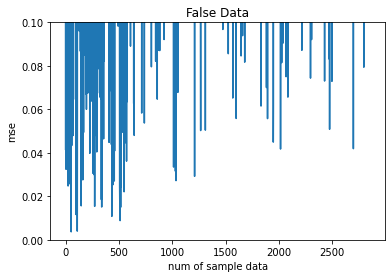

In [78]:
predict_false = lstm_ae.predict(x_scale_false)
mse_false = np.mean(np.power(flatten(x_scale_false) - flatten(predict_false), 2), axis=1)

plt.plot(np.linspace(0, len(mse_false)-1, len(mse_false)), mse_false)
plt.ylim([0, 0.1])
plt.title('False Data')
plt.ylabel('mse')
plt.xlabel('num of sample data')
plt.show()

In [81]:
mse_false[0]

1.4803754789791304

55/55 [==============================] - 0s 4ms/step


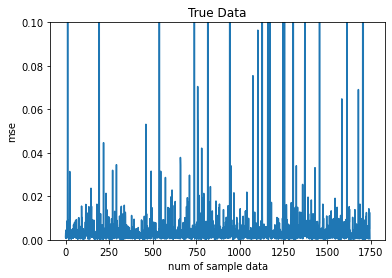

In [64]:
predict_valid = lstm_ae.predict(x_valid)
mse_valid = np.mean(np.power(flatten(x_valid) - flatten(predict_valid), 2), axis=1)

plt.plot(np.linspace(0, len(mse_valid)-1, len(mse_valid)), mse_valid)
plt.ylim([0, 0.1])
plt.title('True Data')
plt.ylabel('mse')
plt.xlabel('num of sample data')
plt.show()

In [45]:
# 특정 mse 기준으로 어떻게 데이터가 나뉘는지 확인
threshold_mse = 0.02

print(predict_false.shape)

(2855, 24, 7)


In [65]:
false_but_true = x_scale_false[mse_false <= threshold_mse].shape[0]
false_but_false = x_scale_false[mse_false > threshold_mse].shape[0]
true_but_true = x_valid[mse_valid <= threshold_mse].shape[0]
true_but_false = x_valid[mse_valid > threshold_mse].shape[0]
print(false_but_true)
print(false_but_false)
print(true_but_true)
print(true_but_false)

14
2841
1698
49


In [66]:
# 정밀도&재현율 계산
print("정밀도 : ", true_but_true/(true_but_true + false_but_true))
print("재현율 : ", true_but_true/(true_but_true + true_but_false))

정밀도 :  0.991822429906542
재현율 :  0.9719519175729823


In [112]:
# 모델 저장
lstm_ae.save('saved_model/v3')

INFO:tensorflow:Assets written to: saved_model/v3/assets


INFO:tensorflow:Assets written to: saved_model/v3/assets
